# Caravan-ESP: datos auxiliares
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 15-08-2023*<br>

**Introducción:**<br>
Para compilar los datos de Caravan son necesarias dos tablas:
* Una tabla con el ID, longitud, latitud, nombre y país de cada una de las estaciones. Las coordenadas deben de estar en el sistema WGS84 (EPSG:4326).
* Una tabla con la serie diaria de caudal específico de cada una de las estaciones.

Además, para publicar el conjunto de datos en Caravan es necesario incluir una capa de polígonos con la cuenca de cada una de las estaciones.

En este _notebook_ se cargan las estaciones seleccionadas para incluir en el conjunto de datos Caravan-ESP, y sus series de caudal diario. Las series de caudal se transforma en caudal específico (caudal dividido por área de la cuenca vertiente, mm/d) y se exportan para su posterior utilización en la generación de Caravan-ESP.

In [18]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm.notebook import tqdm
import yaml
from pathlib import Path
import pickle
import random

from anuario_aforos import dividir_periodo_estudio

## Configuración

In [24]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_anuario = Path(cfg['rutas'].get('anuario_aforos', '../data/anuario_aforos/'))
path_caravan = Path(cfg['rutas'].get('caravan', '../data/caravan/'))

# inicio y fin del periodo de estudio
start = cfg['periodo'].get('inicio', None)
end = cfg['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# tamaño de las muestras de entrenamiento y validación
train_size = cfg.get('train_size', .6)
assert 0 < train_size <= 1., '"train_size" debe de ser un valor entre 0 y 1'
val_size = cfg.get('val_size', .2)
assert 0 < val_size <= 1., '"train_size" debe de ser un valor entre 0 y 1'
if train_size + val_size > 1:
    val_size = 1 - train_size
    print(f'El valor de "val_size" fue truncado a {val_size:.2f}')
seed = cfg.get('seed', 0)
random.seed(seed)

## Datos
### Atributos CARAVAN-ESP

In [5]:
# cargar tabla de atributos de Caravan
atributos = pd.read_csv(path_caravan / 'attributes/attributes.csv', index_col=0)
atributos.index = [id.split('_')[-1] for id in atributos.index]

print('nº de estaciones:\t{0}\nnº de atributos:\t{1}'.format(*atributos.shape))

nº de estaciones:	285
nº de atributos:	197


### Estaciones 

In [62]:
# cargar estaciones
estaciones = gpd.read_file(path_in / 'GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)
estaciones = estaciones.loc[atributos.index]

n_estaciones = estaciones.shape[0]
print('nº de estaciones en la capa de puntos:\t{0}'.format(n_estaciones))

nº de estaciones en la capa de puntos:	285


In [7]:
# exportar
estaciones.index.name = 'indroea'
estaciones.to_csv(path_caravan / f'stations_camelsesp_{n_estaciones}.csv', float_format='%.4f')

**Definir estaciones de entrenamiento y validación**

In [49]:
# listado de estaciones
ids = estaciones.index.to_list()

# definir las estaciones de evaluación
if train_size + val_size < 1.:
    test_size = 1 - train_size - val_size
    n_test = int(estaciones.shape[0] * test_size)
    ids_test = random.sample(ids, n_test)
    ids = [id for id in ids if id not in ids_test]
else:
    test_size = None
    ids_test = []
    
# estaciones de validación
n_val = int(estaciones.shape[0] * val_size)
ids_val = random.sample(ids, n_val)

# estaciones de entrenamiento
ids_cal = [id for id in ids if id not in ids_val]

assert len(ids_cal) + len(ids_val) + len(ids_test) == estaciones.shape[0], 'La unión de las estaciones de calibración, '

# exportar los conjuntos de etaciones
basins = {'train': ids_cal, 'validation': ids_val}
if test_size is not None:
    basins.update({'test': ids_test})
for key, ls in basins.items():
    with open(path_caravan / f'{key}_basins.txt', 'w') as file:
        for id in ls:
            file.write(id + '\n')

### Subcuencas

In [8]:
# cargar polígonos de las cuencas de Caravan
cuencas = gpd.read_file(path_in / 'GIS/subcuencas_epsg4326.shp')
cuencas.set_index('gauge_id', drop=True, inplace=True)

# recortar cuencas según la tabla de atributos
cuencas = cuencas.loc[estaciones.index, :]

# generar nuevos campos
cuencas['gauge_name'] = estaciones.lugar
cuencas['gauge_lat'] = estaciones.latwgs84
cuencas['gauge_lon'] = estaciones.longwgs84
cuencas['country'] = 'Spain'
cuencas['area_skm'] = cuencas.Shape_Area
cuencas.area_skm = cuencas.area_skm.astype(int)

# eliminar campos
cuencas.drop(['HydroID', 'Shape_Area'], axis=1, inplace=True)

# reordenar
cuencas = cuencas[['gauge_name', 'gauge_lat', 'gauge_lon', 'country', 'area_skm', 'geometry']]

n_cuencas = cuencas.shape[0]
print('nº de cuencas en la capa de polígonos:\t{0}'.format(n_cuencas))

nº de cuencas en la capa de polígonos:	285


In [9]:
# exportar
cuencas.to_file(path_caravan / f'catchments_camelsesp_{n_cuencas}.shp', driver='ESRI Shapefile')

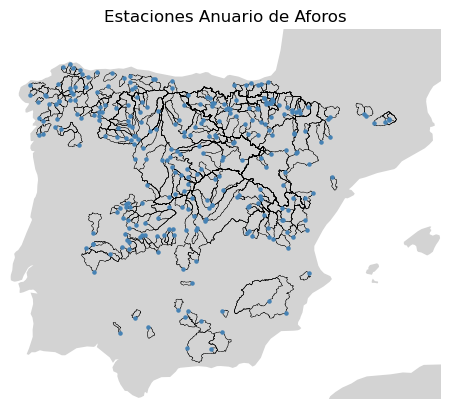

In [10]:
# plot estaciones
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.3);
ax.scatter(estaciones.geometry.x, estaciones.geometry.y, c='steelblue', s=5, alpha=1, label='Anuario')
ax.set_title('Estaciones Anuario de Aforos')
ax.axis('off');

# plt.savefig(f'{path_plots}estaciones.jpg', dpi=300, bbox_inches='tight');

### Caudal

In [51]:
# cargar series de caudal
caudal = pd.read_parquet(path_in / 'caudal.parquet', columns=estaciones.index)
caudal = caudal.loc[start:end,:]

**Series de caudal específico**

In [52]:
# calcular caudal específico
caudal_esp = caudal / estaciones.suprest * 3600 * 24 * 10e-3 # mm/d
caudal_esp.index.name = 'date'

In [54]:
# exportar
n_series = caudal_esp.shape[1]
# caudal_esp.to_parquet(path_out / f'specific_discharge_camelsesp_{n_series}.parquet')
caudal_esp.to_csv(path_caravan / f'specific_discharge_camelsesp_{n_series}.csv', float_format='%.2f')

**Definir periodos de calentamiento, validación y test**

In [63]:
# definir periodos de calibración, validación y evaluación para cada estación
periodos = xr.Dataset({stn: dividir_periodo_estudio(caudal[stn], *estaciones.loc[stn, ['inicio', 'fin']]) for stn in caudal.columns}).to_array(dim='id')

# reorganizar el diccionario
dct = {}
for p in periodos.period.data:
    dct[p] = {}
    for id in periodos.id.data:
        dct[p][id] = {f'{key}_dates': [date] for key, date in periodos.sel(period=p, id=id).to_pandas().to_dict().items()}

# guardar los periodos como pickle
for key, dct in dct.items():
    with open(f'{key}_periods.pkl', 'wb') as f:
        pickle.dump(dct, f)